In [24]:
%gui qt
from collections import defaultdict
from datetime import datetime
from time import time
from stl import mesh
from mayavi import mlab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from kifmm_py import KiFmm, RandomSvdSettings

In [25]:
def read_stl_triangle_mesh_vertices(filepath, dtype=np.float32):
    """Read STL into Fortran ordered NumPy array"""
    m = mesh.Mesh.from_file(filepath).vectors

    faces = m.reshape(-1, 3)
    faces = np.arange(faces.shape[0]).reshape(-1, 3)  # Assuming each face is a triangle

    x = m[:, :, 0].flatten()
    y = m[:, :, 1].flatten()
    z = m[:, :, 2].flatten()

    # Return as a single Fortran order array
    n = len(x)
    result = np.zeros((n, 3)).astype(dtype)
    result[:, 0] = x
    result[:, 1] = y
    result[:, 2] = z
    return (result, faces)

In [26]:
(sources, faces) = read_stl_triangle_mesh_vertices("battleship.STL")
x = sources[:, 0]
y = sources[:, 1]
z = sources[:, 2]

In [27]:
mlab.view(azimuth=40, elevation=70, distance="auto", focalpoint="auto")
fig = mlab.figure(
    size=(960, 1080), bgcolor=(1, 1, 1)
)  # This sets the window size for rendering
plot = mlab.triangular_mesh(
    x, y, z, faces, color=(0.5, 0.5, 0.5), representation="surface", figure=fig
)
mlab.show()

In [31]:
dim = 3
dtype = np.float64

# Set FMM Parameters
expansion_order = 9
n_vec = 1
n_crit = 10
n_sources = sources.shape[0]
n_targets = sources.shape[0]
kernel = "laplace"  # Or 'helmholtz'
field_translation = "blas"  # Or 'fft'
kernel_eval_type = "eval"  # For potential graidents, or 'eval' for potentials only
surface_diff = 2

svd_settings = RandomSvdSettings(None, 10, None, None)

# Set Random charges
charges = np.reshape(
    np.random.rand(n_sources * n_vec), (n_sources, n_vec)
).astype(dtype)

sources = sources.astype(dtype)

fmm = KiFmm(
    expansion_order,
    sources,
    sources,
    charges,
    kernel_eval_type,
    kernel,
    field_translation,
    svd_threshold=None,  # Optional, required for 'blas' based field translations
    n_crit=n_crit,
    surface_diff=surface_diff,
    timed=True
)

In [32]:
fmm.target_leaves.shape

(8912,)

In [33]:
fmm.evaluate()

In [34]:
t = datetime.min 
for op, time in fmm.times.items():
    t += time
runtime = t.second + t.microsecond/1e6
runtime

4.904103

# Plot Solution

In [35]:
potentials = fmm.all_potentials()

reordered = np.zeros_like(potentials)
for i, j in enumerate(fmm.target_global_indices):
    reordered[0][j] = potentials[0][i]

In [36]:
mlab.view(azimuth=40, elevation=70, distance="auto", focalpoint="auto")
fig = mlab.figure(
    size=(960, 1080), bgcolor=(1, 1, 1)
)  # This sets the window size for rendering
solution = mlab.triangular_mesh(
    x, y, z, faces, scalars=np.log(reordered).flatten(), representation="surface"
)

colorbar = mlab.colorbar(solution, title='Log-scaled values', orientation='vertical')
colorbar.title_text_property.font_size = 10
colorbar.label_text_property.font_size = 8
mlab.show()

# Statistics

In [56]:
# Examine result at leaf index
leaf = fmm.target_leaves[23]
found = fmm.potentials(leaf)[0]
targets_leaf = fmm.target_coordinates(leaf)
expected = fmm.evaluate_kernel(sources, targets_leaf, charges)

# Test
np.testing.assert_allclose(found, expected, rtol=1e-11)

In [48]:
stats = defaultdict(int)

for leaf in fmm.target_leaves:
    found = fmm.target_coordinates(leaf)
    n = found.shape[0]
    stats[n] += 1

In [49]:
# ! ls /Users/sri/Downloads/cmu/

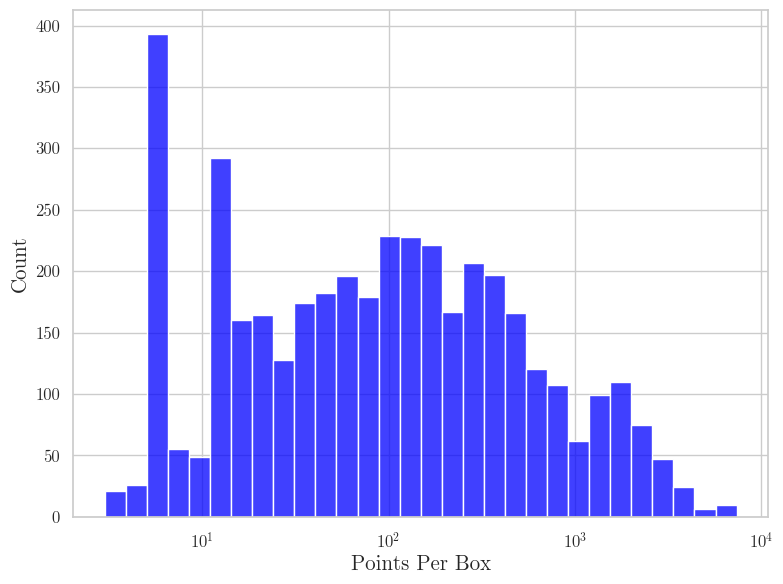

In [54]:
# # Plot the histogram using seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))

# Convert the dictionary to a pandas DataFrame
data = []
for points, occurrences in stats.items():
    data.extend([points] * occurrences)

df = pd.DataFrame(data, columns=['Points'])

hist_plot = sns.histplot(df, x='Points', bins=30, color='blue', log_scale=(True, False))

# Load CMU font
# Update this path to where the CMU Serif font is located
import matplotlib.font_manager as fm
font_path = "/Users/sri/Downloads/cmu/cmunrm.ttf"
font_properties = fm.FontProperties(fname=font_path)

# # Customize the plot for publication quality
# hist_plot.set_title('Histogram of Points in Boxes', fontsize=20)
hist_plot.set_xlabel('Points Per Box', fontsize=15, fontproperties=font_properties)
hist_plot.set_ylabel('Count', fontsize=15, fontproperties=font_properties)
# Set font properties for tick labels
for label in hist_plot.get_xticklabels():
    label.set_fontproperties(font_properties)
for label in hist_plot.get_yticklabels():
    label.set_fontproperties(font_properties)

plt.tight_layout()
plt.savefig('stats.svg', format='svg')
plt.show()